# Mixture Density Network - Inverse problem (normal)

## Import libraries

In [150]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras.optimizers import RMSprop, Adam

import edward as ed
from edward.models import Categorical, Normal, Beta, PointMass
from edward.models import Mixture, Categorical, Normal

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.interpolate import interp1d
from scipy import optimize

## Build data

In [151]:
n_data = 5000
y_data = np.random.uniform(-10.5, 10.5, n_data)
r_data = np.random.normal(size=n_data)  # random noise
x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
x_data = x_data.reshape((n_data, 1))

x_min = x_data.min()-0.00001
x_max = x_data.max()+0.00001

x_data = (x_data-x_min)/(x_max-x_min)

y_min = y_data.min()-0.00001
y_max = y_data.max()+0.00001

y_data = (y_data-y_min)/(y_max-y_min)

## Visualize data

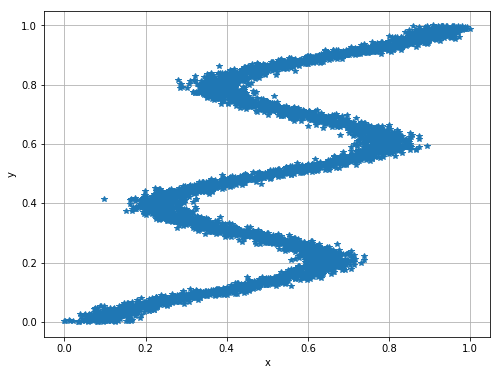

In [165]:
plt.figure(figsize=(8,6))
plt.plot(x_data, y_data, '*')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

## Create supervised problem

In [166]:
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, shuffle=True)
print('Data points in train set: {0}.'.format(len(X_train)))
print('Data points in test set: {0}.'.format(len(X_test)))
print("Shape of features in training data: {}".format(X_train.shape))
print("Shape of output in training data: {}".format(y_train.shape))
print("Shape of features in test data: {}".format(X_test.shape))
print("Shape of output in test data: {}".format(y_test.shape))

Data points in train set: 3750.
Data points in test set: 1250.
Shape of features in training data: (3750, 1)
Shape of output in training data: (3750,)
Shape of features in test data: (1250, 1)
Shape of output in test data: (1250,)


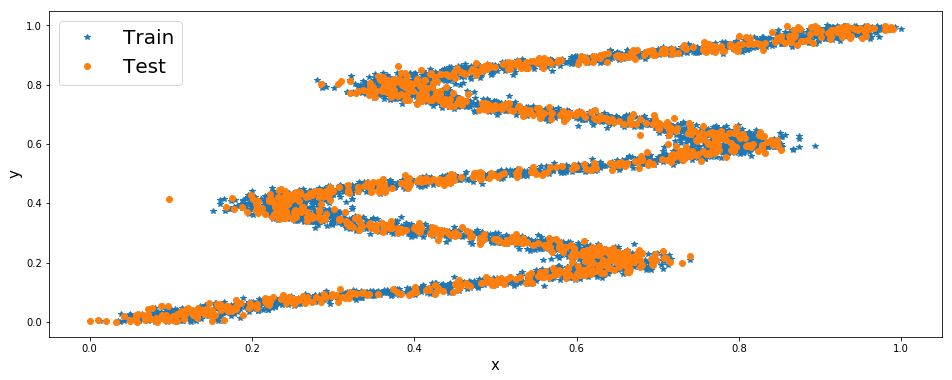

In [167]:
plt.figure(figsize=(16,6))
plt.plot(X_train, y_train, '*', label='Train')
plt.plot(X_test, y_test, 'o', label='Test')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)
plt.show()

## Build mixture density network

In [168]:
def neural_network_keras(X, K):
    h = Dense(units=32, activation='relu')(X)
    h = Dense(units=32, activation='relu')(h)
    h = Dense(units=32, activation='relu')(h)
    weights = Dense(units=K, activation='linear')(h)
    mus = Dense(units=K, activation='linear')(h)
    sigmas = Dense(units=K, activation=tf.exp)(h)
    
    return weights, mus, sigmas

In [169]:
X_ph = tf.placeholder(tf.float32, [None, D])
y_ph = tf.placeholder(tf.float32, [None])

In [170]:
K = 10    # Number of mixture components
weights, mus, sigmas = neural_network_keras(X_ph, K)
cat = Categorical(logits=weights)
components = []
components.extend([Normal(loc=mu, scale=sigma) for mu, sigma 
                   in zip(tf.unstack(tf.transpose(mus)),tf.unstack(tf.transpose(sigmas)))])
y = Mixture(cat=cat, components=components)

## Inference

In [171]:
inference = ed.MAP(data={y: y_ph})

optim = 'Adam'
if optim == 'Adam':
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3,
                                       beta1=0.9,
                                       beta2=0.999,
                                       epsilon=1e-08)
elif optim == 'RMSprop':
    optimizer = tf.train.RMSPropOptimizer(learning_rate=1e-3,
                                          decay=0.9,
                                          epsilon=1e-10)
    
inference.initialize(optimizer=optimizer, var_list=tf.trainable_variables())

In [172]:
sess = ed.get_session()
tf.global_variables_initializer().run()

In [173]:
n_epoch = 0
train_loss = np.array([])
test_loss = np.array([])

In [174]:
n_epoch_add = 1000
train_loss = np.concatenate((train_loss,np.zeros(n_epoch_add)))
test_loss = np.concatenate((test_loss,np.zeros(n_epoch_add)))
inference.n_print = 10
inference.progbar.target = n_epoch+n_epoch_add
for i in range(n_epoch,n_epoch+n_epoch_add):
    info_dict = inference.update(feed_dict={X_ph: X_train, y_ph: y_train})
    train_loss[i] = info_dict['loss']
    test_loss[i] = sess.run(inference.loss, feed_dict={X_ph: X_test, y_ph: y_test})
    inference.print_progress(info_dict)

n_epoch = n_epoch+n_epoch_add

1000/1000 [100%] ██████████████████████████████ Elapsed: 22s | Loss: -5156.903


## Plot training diagnostics

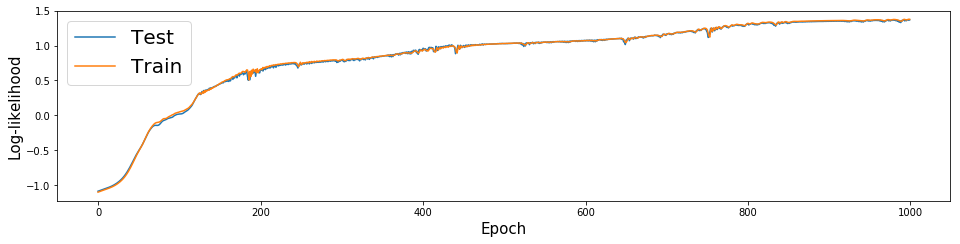

In [175]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(n_epoch), -test_loss / len(X_test), label='Test')
plt.plot(np.arange(n_epoch), -train_loss / len(X_train), label='Train')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Log-likelihood', fontsize=15)
plt.show()

## Make prediction

In [176]:
n_pred = 100
X_pred = np.reshape(np.linspace(X_train.min(), X_train.max(), n_pred), (n_pred, 1))

In [177]:
train_weights, train_mus, train_sigmas = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_train})
test_weights, test_mus, test_sigmas = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_test})
pred_weights, pred_mus, pred_sigmas = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_pred})

## Plot result

### Plot distribution

In [188]:
def plot_normal_mix(pis, mus, sigmas, x_true, y_true, comp=True):
    fig, ax = plt.subplots(1,1,figsize=(16,6))
    y = np.linspace(0, 1, 1000)
    final = np.zeros_like(y)
    for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
        temp = weight_mix * stats.norm.pdf(y, mu_mix, sigma_mix)
        final = final + temp
        if comp:
            ax.plot(y, temp, label='beta ' + str(i))
    ax.plot(y, final, label='Mixture of betas')
    ax.axvline(x=y_true, linestyle='--', color='k', label='True value')
    ax.legend(fontsize=13)
    plt.title('True x-value: '+str(x_true[0]))

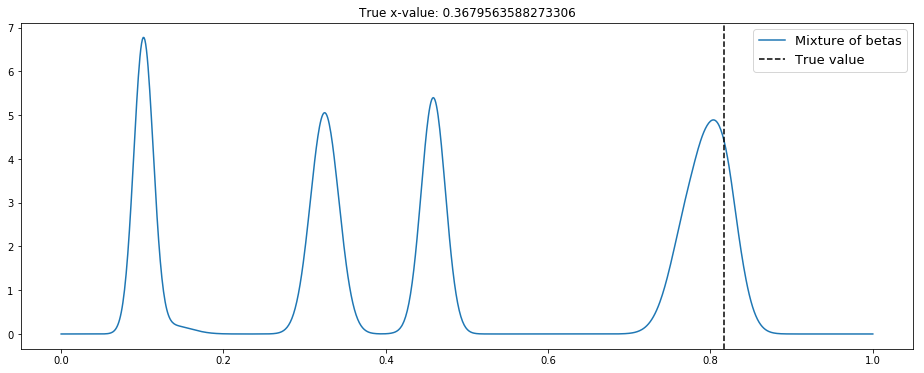

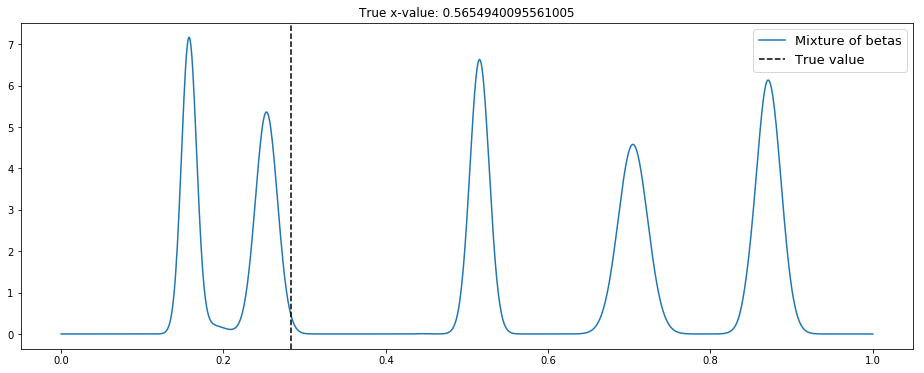

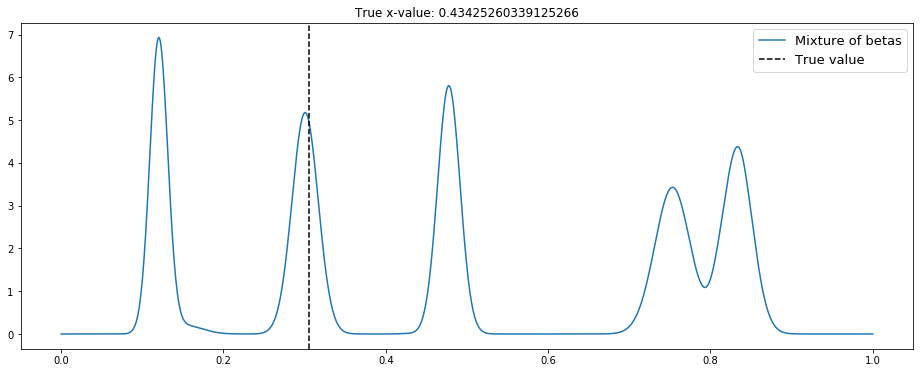

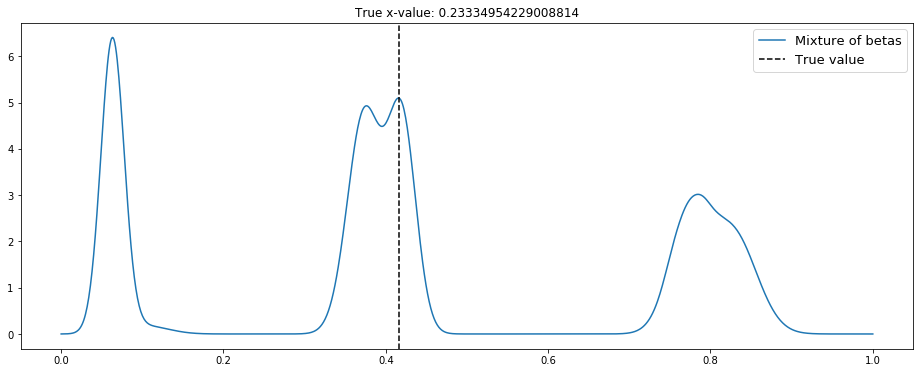

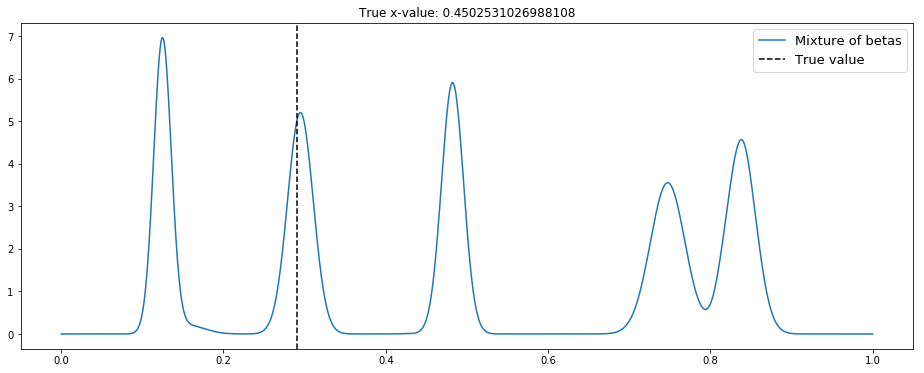

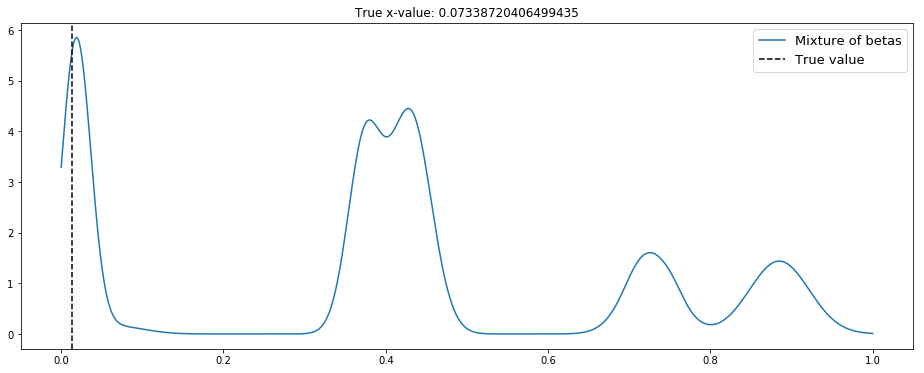

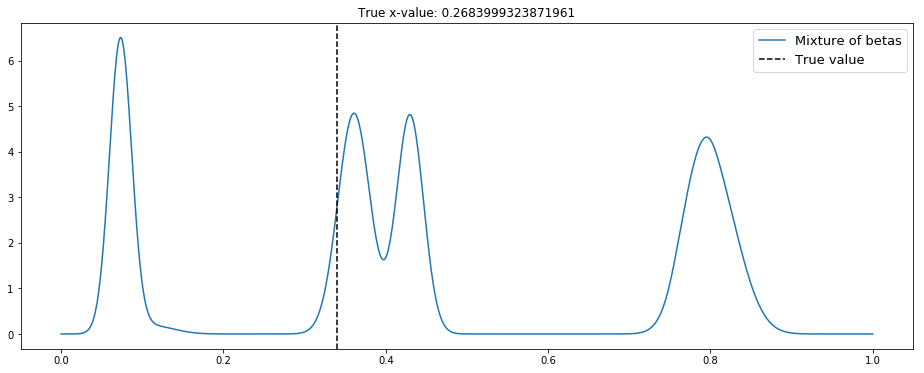

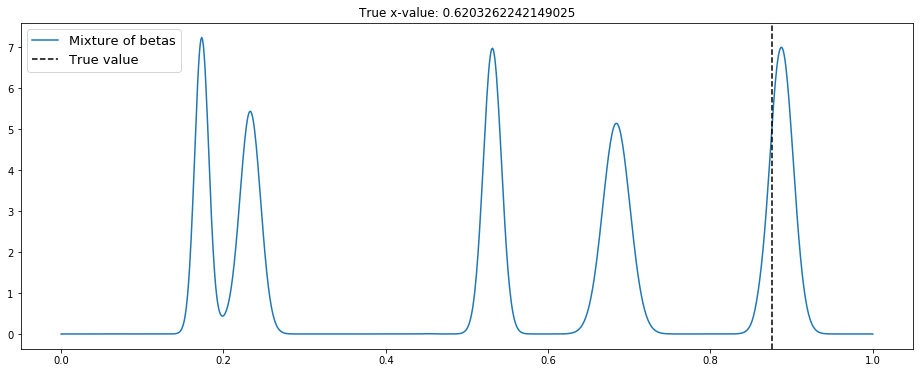

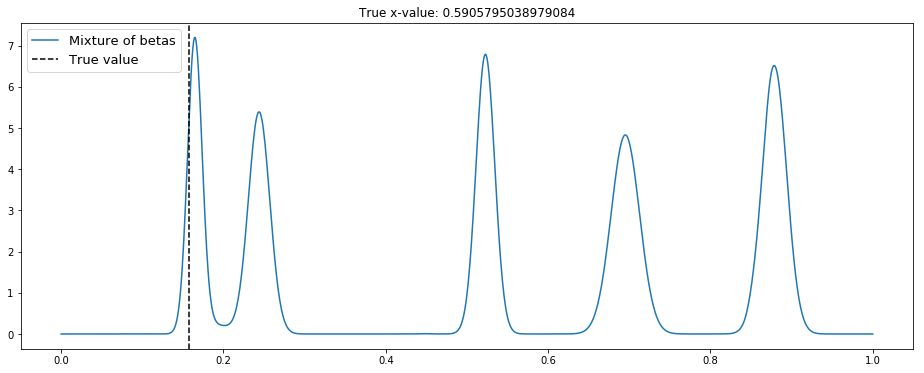

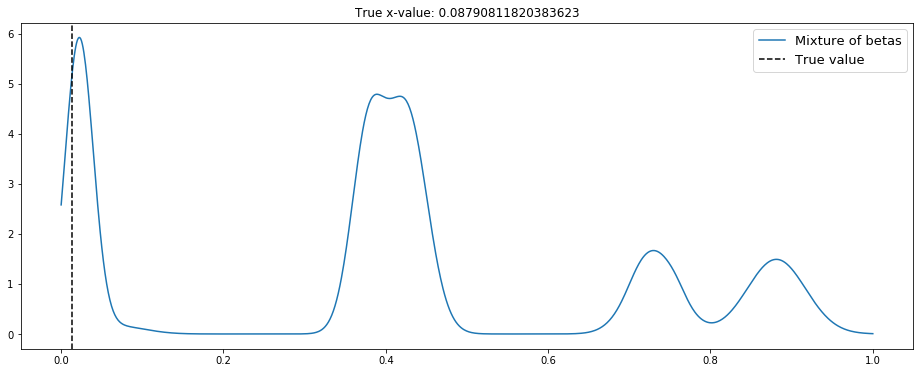

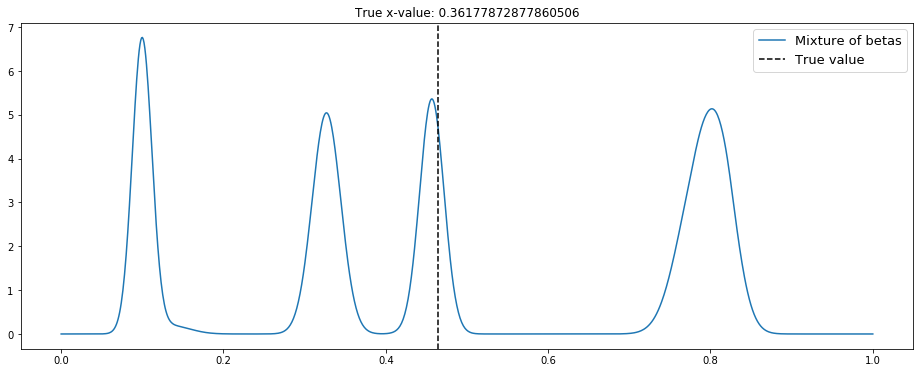

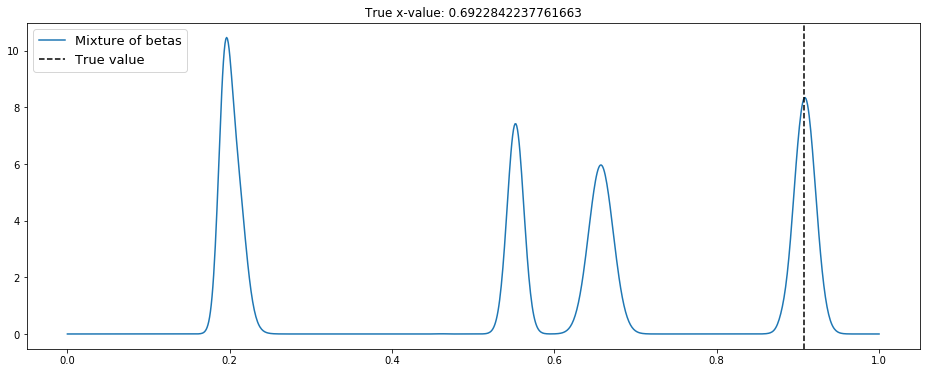

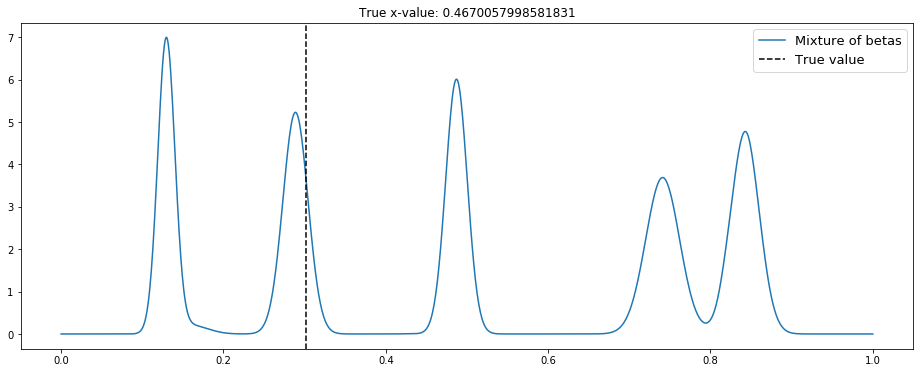

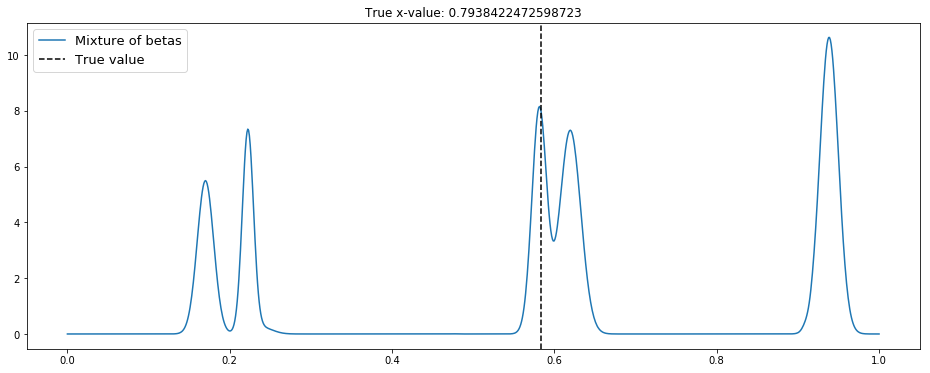

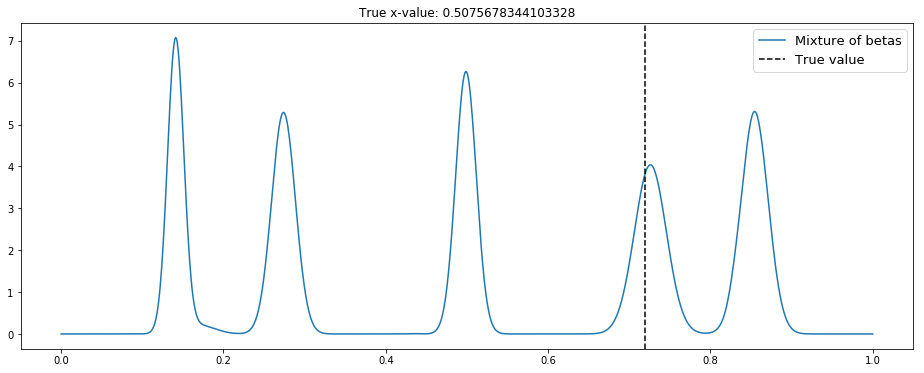

In [189]:
ns = np.random.randint(0, high=len(X_test), size=15)
for n in ns: 
    plot_normal_mix(test_weights[n,:], test_mus[n,:], test_sigmas[n,:], X_test[n], y_test[n], comp=False)

### Plot samples

In [179]:
def sample_from_mixture(x, pred_weights, pred_mus, pred_sigmas, amount):

    samples = np.zeros((amount, 2))
    n_mix = len(pred_weights[0])
    to_choose_from = np.arange(n_mix)
    for j, (weights, mus, sigmas) in enumerate(zip(pred_weights, pred_mus, pred_sigmas)):
        index = np.random.choice(to_choose_from, p=weights)
        samples[j, 1] = np.random.normal(mus[index], sigmas[index], size=1)
        samples[j, 0] = x[j]
        if j == amount - 1:
            break
        
    return samples

In [180]:
samples = sample_from_mixture(X_test, test_weights, test_mus, test_sigmas, amount=len(X_test))

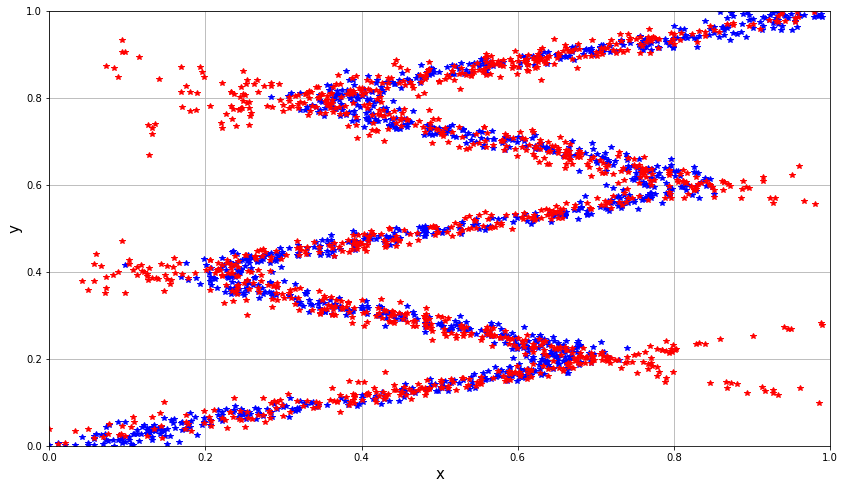

In [186]:
plt.figure(figsize=(14,8))
plt.plot(X_test, y_test,'b*')
plt.plot(samples[:,0], samples[:,1],'r*')
plt.axis([0,1,0,1]);
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.grid()

### Plot means

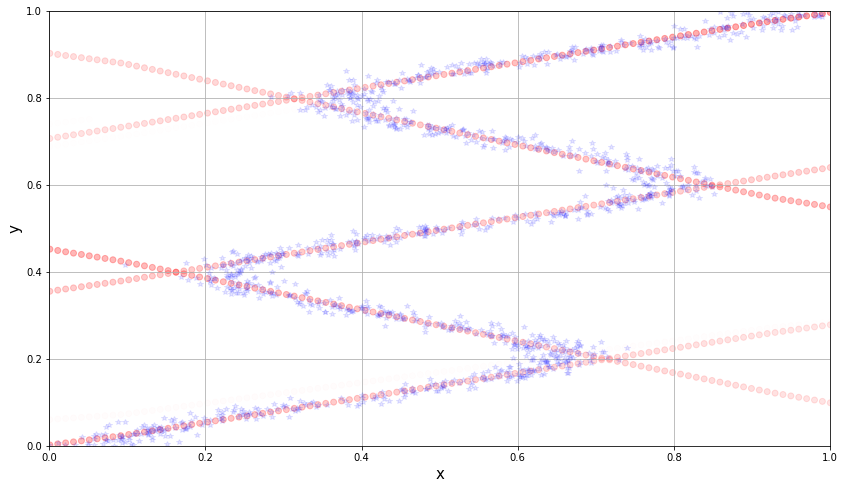

In [187]:
plt.figure(figsize=(14,8))
plt.plot(X_test, y_test, 'b*', alpha=0.1)
rgba_colors = np.zeros((n_pred,4))
rgba_colors[:,0] = 1.0
for i in range(K):
    rgba_colors[:, 3] = pred_weights[:,i]
    plt.scatter(X_pred, pred_mus[:,i], color=rgba_colors)

plt.axis([0,1,0,1]);
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.grid()